# Matching Gravitationally Lensed SNe (GLSNe) Lens Galaxies to CosmoDC2 galaxies

Last updated: _Bryce Kalmbach, December 2018_

Danny Goldstein's latest strongly lensed SNe catalog has all the properties needed to replace galaxies from DC2 with the sprinkler except for SEDs and CatSim magNorm values for the lens galaxies. This notebook matches the lensed SNe lens galaxies to a DC2 galaxy then uses `sims_GCRCatSimInterface` and the given 'i-band' magnitude from the lens catalog to calculate an appropriate magNorm value and SED.


## Requirements

You will need `gcrCatalogs`, `GCR`, `pandas`, `numpy` and `matplotlib`

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
import os
from lsst.sims.photUtils import Sed, Bandpass, BandpassDict, getImsimFluxNorm

%matplotlib inline

Set the `gcr-catalog` version you need below and all names of outputs will be consistent.

In [2]:
catalog_version = 'cosmoDC2_v1.1.4'

#### Load up the input lensed SNe catalogs

In [3]:
dc2_df_system = pd.read_hdf('../data/glsne_dc2_v2.h5', key='system')
dc2_df_image = pd.read_hdf('../data/glsne_dc2_v2.h5', key='image')

In [4]:
import GCRCatalogs
import pandas as pd
from GCR import GCRQuery

#### Choose an area of the DC2 catalog to use for matching galaxies

In [5]:
# _small version of cosmoDC2 catalog will work for this
catalog = GCRCatalogs.load_catalog('%s_small' % catalog_version)

In [6]:
# Example lens catalog row.
dc2_df_system.iloc[0]

t0                               62307.9
sigma                             197.67
gamma                           0.128101
e                               0.570391
theta_e                          132.165
theta_gamma                       135.21
zs                              0.435736
zl                              0.152485
snx                            -0.136216
sny                             0.144903
MB                              -19.3306
transient_amplitude          7.78584e-10
sysno                               2237
sntype                                1a
ebvhost                        0.0735387
ra                               132.817
dec                             -34.6162
ebvmw                           0.283343
weight                       0.000133177
host_n                                 1
host_ellip                          0.84
host_reff                       0.810876
host_theta                       5.70672
host_amplitude               4.93238e-17
host_type       

#### Get all the galaxies from the catalog that are within the redshift range and i-band magnitude range of the lens galaxies

In [ ]:
%%time
z_cat_min = np.power(10, np.log10(np.min(dc2_df_system['zl'])) - .1)
z_cat_max = np.power(10, np.log10(np.max(dc2_df_system['zl'])) + .1)

i_gal_dim = np.max(-2.5*np.log10(np.power(10, -0.4*dc2_df_system['lensgal_mi'])*.9))
i_gal_bright = np.min(-2.5*np.log10(np.power(10, -0.4*dc2_df_system['lensgal_mi'])*1.1))

print(z_cat_min, z_cat_max, i_gal_dim, i_gal_bright)

data = catalog.get_quantities(['galaxy_id', 'redshift_true', 'ellipticity_true', 'mag_true_i_lsst',
                               'size_minor_bulge_true', 'size_bulge_true'],
                              filters=['mag_true_i_lsst > %f' % i_gal_bright,
                                       'mag_true_i_lsst < %f' % i_gal_dim,
                                       'redshift_true > %f' % z_cat_min, 'redshift_true < %f' % z_cat_max,
                                       'stellar_mass_bulge/stellar_mass > 0.99'])

data['glsne_ellipticity'] = (1-(data['size_minor_bulge_true']/data['size_bulge_true']))


data_df = pd.DataFrame(data)
print(data_df.head(10))

In [19]:
#data_df.to_csv('../data/sn_matching_checkpoint_1.csv', index=False)

In [26]:
data_df = pd.read_csv('../data/sn_matching_checkpoint_1.csv')
i_gal_dim = np.max(-2.5*np.log10(np.power(10, -0.4*dc2_df_system['lensgal_mi'])*.9))
i_gal_bright = np.min(-2.5*np.log10(np.power(10, -0.4*dc2_df_system['lensgal_mi'])*1.1))
z_cat_min = np.power(10, np.log10(np.min(dc2_df_system['zl'])) - .1)
z_cat_max = np.power(10, np.log10(np.max(dc2_df_system['zl'])) + .1)

#### Use this set of DC2 galaxies to then match to each lens galaxy in the catalog based upon redshift and i-band apparent magnitude

In [11]:
%%time
gcr_glsn_match = []
err = 0
np.random.seed(10)
i = 0

row_num = -1
keep_rows = []
num_match_total = []

for zsrc, i_mag_star in zip(dc2_df_system['zl'].values,
                            dc2_df_system['lensgal_mi'].values):

    row_num += 1
    #print(zsrc, m_star, ellip)
    if row_num % 10000 == 0:
        print(row_num)

    z_min, z_max = np.power(10, np.log10(zsrc) - .1), np.power(10, np.log10(zsrc) + .1)
    i_mag_dim, i_mag_bright = -2.5*np.log10(np.power(10, -0.4*i_mag_star)*.9),\
                              -2.5*np.log10(np.power(10, -0.4*i_mag_star)*1.1)
    #ellip_min, ellip_max = ellip*.9, ellip*1.1
    #r_major = r_eff / np.sqrt(1 - ellip)
    #r_major_max, r_major_min = r_major*1.1, r_major*.9
    
    
    #print(z_min, z_max, i_mag_min, i_mag_max, ellip_min, ellip_max)
    
    data_subset = data_df.query('redshift_true > %f and redshift_true < %f ' % (z_min, z_max)
                                + 'and mag_true_i_lsst > %f and mag_true_i_lsst < %f ' % (i_mag_bright, i_mag_dim)
                                #+ 'and glsne_ellipticity > %f and glsne_ellipticity < %f' % (ellip_min, ellip_max)
                                #+ 'and size_bulge_true > %f and size_bulge_true < %f' % (r_major_min, r_major_max)
                               )
    
    num_matches = len(data_subset['redshift_true'])

    num_match_total.append(num_matches)
    
    if num_matches == 0:
        err += 1
        continue
    elif num_matches == 1:
        gcr_data = [data_subset['redshift_true'].values[0], 
                    data_subset['galaxy_id'].values[0]]
        gcr_glsn_match.append(gcr_data)
        keep_rows.append(row_num)
    elif num_matches > 1:
        use_idx = np.random.choice(num_matches)
        gcr_data = [data_subset['redshift_true'].values[use_idx],
                    data_subset['galaxy_id'].values[use_idx]]
        gcr_glsn_match.append(gcr_data)
        keep_rows.append(row_num)
        
print("Total Match Failures: ", err, " Percentage Match Failures: ", np.float(err)/len(dc2_df_system))

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
160000
170000
180000
190000
Total Match Failures:  20578  Percentage Match Failures:  0.10455291409874047
CPU times: user 1h 9min 18s, sys: 25min 39s, total: 1h 34min 57s
Wall time: 1h 34min 58s


In [12]:
gcr_glsn_match = np.array(gcr_glsn_match)
keep_rows = np.array(keep_rows)

(array([37711., 38163., 25933., 22771., 14710.,  9797.,  7630.,  5781.,
         3580.,  2759.,  2281.,  1530.,   980.,   654.,   514.,   409.,
          294.,   228.,   151.,   129.]),
 array([0.01500018, 0.06418905, 0.11337791, 0.16256678, 0.21175564,
        0.2609445 , 0.31013337, 0.35932223, 0.4085111 , 0.45769996,
        0.50688883, 0.55607769, 0.60526655, 0.65445542, 0.70364428,
        0.75283315, 0.80202201, 0.85121088, 0.90039974, 0.94958861,
        0.99877747]),
 <a list of 20 Patch objects>)

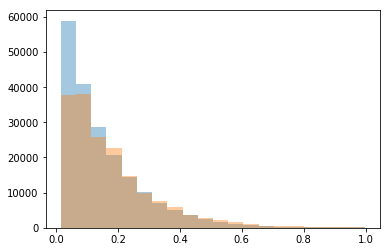

In [13]:
n, bins, _ = plt.hist(dc2_df_system['zl'], alpha=0.4, bins=20)
plt.hist(gcr_glsn_match[:,0], alpha=0.4, bins=bins)

In [14]:
np.savetxt('../data/gcr_glsn_match.txt', gcr_glsn_match)
np.savetxt('../data/keep_rows_sn.txt', keep_rows)

It seems we are missing mostly very low redshift systems. This is most likely a result of our percentage bounds on redshift. However, we still have nearly 40000 systems in this low redshift range and will have enough to match.

## Matching to SEDs using `sims_GCRCatSimInterface`

Our goal is to add SEDs and magNorm values into the lensing catalogs for the lens galaxies. Here we get the top hat filters out of cosmoDC2 and use the code in `sims_GCRCatSimInterface` to match these values to a CATSIM SED file in the same way the galaxies are matched for Instance Catalog production in DC2. We also use the code to calculate the magnitude normalization for PhoSim.

In [15]:
import sys
sys.path.append('/global/homes/b/brycek/DC2/sims_GCRCatSimInterface/workspace/sed_cache/')

In [16]:
from SedFitter import sed_from_galacticus_mags

In [17]:
H0 = catalog.cosmology.H0.value
Om0 = catalog.cosmology.Om0

In [18]:
sed_label = []
sed_min_wave = []
sed_wave_width = []
for quant_label in sorted(catalog.list_all_quantities()):
    if (quant_label.startswith('sed') and quant_label.endswith('bulge')):
        sed_label.append(quant_label)
        label_split = quant_label.split('_')
        sed_min_wave.append(int(label_split[1])/10)
        sed_wave_width.append(int(label_split[2])/10)
bin_order = np.argsort(sed_min_wave)
sed_label = np.array(sed_label)[bin_order]
sed_min_wave = np.array(sed_min_wave)[bin_order]
sed_wave_width = np.array(sed_wave_width)[bin_order]

Check to see that our bins are now in order when we call them.

In [19]:
for i in zip(sed_label, sed_min_wave, sed_wave_width):
    print(i)

('sed_1000_246_bulge', 100.0, 24.6)
('sed_1246_306_bulge', 124.6, 30.6)
('sed_1552_381_bulge', 155.2, 38.1)
('sed_1933_474_bulge', 193.3, 47.4)
('sed_2407_591_bulge', 240.7, 59.1)
('sed_2998_186_bulge', 299.8, 18.6)
('sed_3184_197_bulge', 318.4, 19.7)
('sed_3381_209_bulge', 338.1, 20.9)
('sed_3590_222_bulge', 359.0, 22.2)
('sed_3812_236_bulge', 381.2, 23.6)
('sed_4048_251_bulge', 404.8, 25.1)
('sed_4299_266_bulge', 429.9, 26.6)
('sed_4565_283_bulge', 456.5, 28.3)
('sed_4848_300_bulge', 484.8, 30.0)
('sed_5148_319_bulge', 514.8, 31.9)
('sed_5467_339_bulge', 546.7, 33.9)
('sed_5806_360_bulge', 580.6, 36.0)
('sed_6166_382_bulge', 616.6, 38.2)
('sed_6548_406_bulge', 654.8, 40.6)
('sed_6954_431_bulge', 695.4, 43.1)
('sed_7385_458_bulge', 738.5, 45.8)
('sed_7843_486_bulge', 784.3, 48.6)
('sed_8329_517_bulge', 832.9, 51.7)
('sed_8846_549_bulge', 884.6, 54.9)
('sed_9395_583_bulge', 939.5, 58.3)
('sed_9978_1489_bulge', 997.8, 148.9)
('sed_11467_1710_bulge', 1146.7, 171.0)
('sed_13177_1966_bulge

In [ ]:
del(data)
del(data_df)

In [27]:
%%time
columns = ['galaxy_id', 'redshift_true', 'mag_u_lsst', 'mag_g_lsst', 'mag_r_lsst',
           'mag_i_lsst', 'mag_z_lsst', 'mag_y_lsst']
for sed_bin in sed_label:
    columns.append(sed_bin)
data = catalog.get_quantities(columns,
                              filters=['mag_true_i_lsst > %f' % i_gal_bright,
                                       'mag_true_i_lsst < %f' % i_gal_dim,
                                       'redshift_true > %f' % z_cat_min, 'redshift_true < %f' % z_cat_max,
                                       'stellar_mass_bulge/stellar_mass > 0.99'])
data_df = pd.DataFrame(data)

CPU times: user 1min 31s, sys: 33.1 s, total: 2min 4s
Wall time: 4min 24s


In [29]:
data_df.to_csv('../data/sn_matching_checkpoint_2.csv', index=False)

In [30]:
# _small version of cosmoDC2 catalog will work for this
# catalog = GCRCatalogs.load_catalog('%s_small' % catalog_version)
data_df = pd.read_csv('../data/sn_matching_checkpoint_2.csv')
gcr_glsn_match = np.genfromtxt('../data/gcr_glsn_match.txt')
keep_rows = np.genfromtxt('../data/keep_rows_sn.txt')

In [31]:
keep_rows = np.array(keep_rows, dtype=int)

In [32]:
%%time
sed_name_list = []
magNorm_list = []
i = 0
lsst_mags = []
mag_30_list = []
redshift_list = []
for gal_id, gal_z in zip(gcr_glsn_match[:, 1], 
                         gcr_glsn_match[:, 0]):
    
    if i % 10000 == 0:
        print(i)
    i+=1
    #print(int(gal_id))
    data_subset = data_df.query(str('galaxy_id == %i' % int(gal_id))) ## Galaxy Ids are not unique in cosmoDC2_v0.1
    #print(data_subset)
    mag_array = []
    lsst_mag_array = [data_subset['mag_%s_lsst' % band_name].values[0] for band_name in ['u', 'g', 'r', 'i', 'z', 'y']]
    for sed_bin in sed_label:
        mag_array.append(-2.5*np.log10(data_subset[sed_bin].values[0]))
    mag_array = np.array(mag_array)
    lsst_mag_array = np.array(lsst_mag_array)
    lsst_mags.append(lsst_mag_array)
    mag_30_list.append(mag_array)
    redshift_list.append(gal_z)
    
mag_30_list = np.array(mag_30_list).T
lsst_mags = np.array(lsst_mags).T
redshift_list = np.array(redshift_list)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
CPU times: user 40min 34s, sys: 771 ms, total: 40min 35s
Wall time: 40min 35s


In [33]:
mag_30_list[:,0], lsst_mags[:,0]

(array([-15.349242  , -15.41242992, -15.49826907, -16.49474803,
        -18.03196643, -19.25693434, -19.66323856, -19.91014889,
        -20.2605061 , -20.53956729, -21.10003776, -21.45802415,
        -21.80329073, -21.89667427, -22.05390246, -22.26704256,
        -22.41313917, -22.50439747, -22.61101951, -22.69651655,
        -22.85008183, -22.94446048, -23.01997205, -23.13748013,
        -23.20623229, -23.27495701, -23.33341805, -23.3831555 ,
        -23.53788553, -23.43094087]),
 array([20.43146993, 18.72356702, 17.61556722, 17.15545751, 16.90777875,
        16.71117116]))

In [34]:
print(np.shape(mag_30_list), np.shape(lsst_mags), np.shape(redshift_list))

(30, 176241) (6, 176241) (176241,)


In [35]:
sed_name, magNorm, av, rv = sed_from_galacticus_mags(mag_30_list, redshift_list,
                                                     H0, Om0, sed_min_wave, sed_wave_width, lsst_mags)
sed_name_list = sed_name
magNorm_list = magNorm
print(len(sed_name_list), len(keep_rows))

176241 176241


In [36]:
sed_name_array = np.array(sed_name_list)
magNorm_array = np.array(magNorm_list)
av_array = np.array(av)
rv_array = np.array(rv)

In [37]:
np.savetxt('../data/sed_name_list_sn.txt', sed_name_array, fmt='%s')
np.savetxt('../data/magNorm_list_sn.txt', magNorm_array)
np.savetxt('../data/av_list_sn.txt', av_array)
np.savetxt('../data/rv_list_sn.txt', rv_array)

In [38]:
sed_name_array = np.genfromtxt('../data/sed_name_list_sn.txt', dtype=np.str)
magNorm_array = np.genfromtxt('../data/magNorm_list_sn.txt')
av_array = np.genfromtxt('../data/av_list_sn.txt')
rv_array = np.genfromtxt('../data/rv_list_sn.txt')
redshift_list = gcr_glsn_match[:,0]

In [39]:
test_bandpassDict = BandpassDict.loadTotalBandpassesFromFiles()

In [40]:
imsimband = Bandpass()
imsimband.imsimBandpass()

In [41]:
mag_norm_glsne = []
test_sed = Sed()
test_sed.readSED_flambda(os.path.join(str(os.environ['SIMS_SED_LIBRARY_DIR']), sed_name_array[0]))
a, b = test_sed.setupCCM_ab()

# We need to adjust the magNorms of the galaxies so that,
# in the i-band, they match the OM10 APMAG_I.
# We do this be calculating the i-magnitudes of the galaxies as they
# will be simulated, finding the difference between that magnitude
# and APMAG_I, and adding that difference to *all* of the magNorms
# of the galaxy (this way, the cosmoDC2 validated colors of the
# galaxies are preserved)

for i, idx in list(enumerate(keep_rows)):
    if i % 10000 == 0:
        print(i, idx)
    test_sed = Sed()
    test_sed.readSED_flambda(os.path.join(str(os.environ['SIMS_SED_LIBRARY_DIR']), sed_name_array[i]))
    fnorm = getImsimFluxNorm(test_sed, magNorm_array[3,i])
    test_sed.multiplyFluxNorm(fnorm)
    test_sed.addDust(a, b, A_v=av_array[i], R_v=rv_array[i])
    test_sed.redshiftSED(redshift_list[i], dimming=True)
    i_mag = test_sed.calcMag(test_bandpassDict['i'])
    d_mag = dc2_df_system['lensgal_mi'].iloc[idx]-i_mag
    mag_norm_glsne.append(magNorm_array[:,i] + d_mag)
    
#     # Double check colors are maintained
#     test_sed = Sed()
#     test_sed.readSED_flambda(os.path.join(str(os.environ['SIMS_SED_LIBRARY_DIR']), sed_name_array[i]))
#     print(magNorm_array[3,i])
#     fn_1 = test_sed.calcFluxNorm(magNorm_array[3,i], imsimband)
#     test_sed.multiplyFluxNorm(fn_1)
#     i_orig = test_sed.calcMag(test_bandpassDict['i'])
#     fn_2 = test_sed.calcFluxNorm(magNorm_array[2,i], imsimband)
#     test_sed.multiplyFluxNorm(fn_2)
#     r_orig = test_sed.calcMag(test_bandpassDict['r'])
#     print(r_orig, i_orig, r_orig-i_orig)
#     fn_3 = test_sed.calcFluxNorm(mag_norm_glsne[-1][2], imsimband)
#     test_sed.multiplyFluxNorm(fn_3)
#     r_new = test_sed.calcMag(test_bandpassDict['r'])
#     print(dc2_df_system['lensgal_mi'].iloc[idx], r_new, r_new - dc2_df_system['lensgal_mi'].iloc[idx])
    
#    print(mag_norm_glsne[-1])

0 0
10000 11175
20000 22364
30000 33457
40000 44654
50000 55834
60000 67027
70000 78113
80000 89351
90000 100541
100000 111636
110000 122832
120000 133938
130000 145110
140000 156280
150000 167539
160000 178714
170000 189842


In [42]:
mag_norm_glsne = np.array(mag_norm_glsne)

In [43]:
sed_metals = []
sed_ages = []
sed_metals_dict = {'0005Z':'.005', '002Z':'.02', '02Z':'.2', '04Z':'.4', '1Z':'1.0', '25Z':'2.5'}
for sed_template in sed_name_array:
    sed_info = sed_template.split('/')[1].split('.')
    sed_age_info = sed_info[1].split('E')
    sed_ages.append(np.power(10, int(sed_age_info[1]))*int(sed_age_info[0]))
    sed_metals.append(sed_metals_dict[sed_info[2]])

Text(0.5, 0.98, 'Age and Metallicity of matched SED templates')

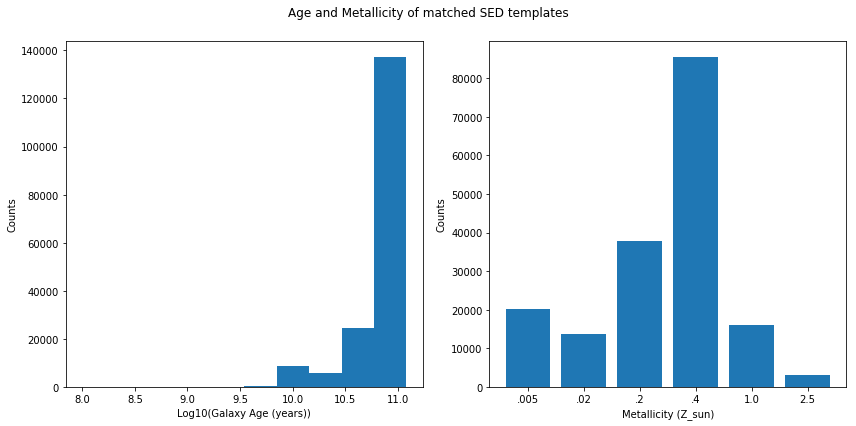

In [44]:
fig = plt.figure(figsize=(12, 6))
mpl.rcParams['text.usetex'] = False
fig.add_subplot(1,2,1)
plt.hist(np.log10(sed_ages))
plt.xlabel('Log10(Galaxy Age (years))')
plt.ylabel('Counts')
fig.add_subplot(1,2,2)
names, counts = np.unique(sed_metals, return_counts=True)
x = np.arange(len(names), dtype=int)
plt.bar(x, counts)
plt.xticks(x, names)
plt.xlabel('Metallicity (Z_sun)')
plt.ylabel('Counts')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle('Age and Metallicity of matched SED templates')

We want our lens galaxies to be large, red ellipticals and it looks like we are getting older, redder galaxies which looks like we are succeeding.

## Add in SNCosmo parameters

We will fit for the SNCosmo `x0` parameter while setting `x1` to 1. and `c` to 0. for all SNe.

In [48]:
dc2_df_system['x1'] = 1.
dc2_df_system['c'] = 0.

In [50]:
import sncosmo
from astropy.cosmology import FlatLambdaCDM

In [51]:
source = sncosmo.get_source('salt2-extended')
model = sncosmo.Model(source=source)

In [52]:
cosmo = FlatLambdaCDM(H0=71, Om0=0.265, Tcmb0=0, Neff=3.04, m_nu=None, Ob0=0.045)

In [54]:
x0 = []
for sn_row_zs, sn_row_mb in zip(dc2_df_system['zs'].values, dc2_df_system['MB'].values):
    z = sn_row_zs
    MB = sn_row_mb
    model.set(z=z)
    model.set_source_peakabsmag(MB, 'bessellb', 'ab', cosmo=cosmo)
    x0.append(model.get('x0'))

In [58]:
dc2_df_system['x0'] = x0
print(dc2_df_system['x0'].head().values)

[1.49012497e-05 3.45494326e-06 1.86039419e-05 3.47243755e-06
 6.17802354e-06]


## Adding new info to Twinkles GLSNe catalog

We will take all the columns currently in the Twinkles GLSNe catalog and add in our new SED filenames and SED magnitude normalizations for PhoSim.

Text(0, 0.5, 'Count')

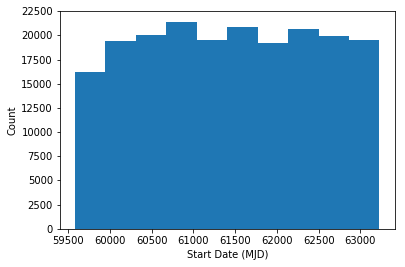

In [45]:
# Double check the distribution of t0
mpl.rcParams['text.usetex'] = False
plt.hist(dc2_df_system['t0'])
plt.xlabel('Start Date (MJD)')
plt.ylabel('Count')

In the final catalog we produce we only want to include the systems we were able to match to a `gcr` galaxy.

In [59]:
results_dict = {}
print(len(keep_rows), len(gcr_glsn_match[:, 0]))
for keep_idx in range(len(keep_rows)):
    results_dict[str(dc2_df_system['sysno'].iloc[keep_rows[keep_idx]])] = {'z':gcr_glsn_match[:, 0][keep_idx],
                                                                           'sed_name':sed_name_array[keep_idx],
                                                                           'magNorm':mag_norm_glsne[keep_idx],
                                                                           'lens_av':av_array[keep_idx],
                                                                           'lens_rv':rv_array[keep_idx]}

176241 176241


In [60]:
keep_systems = dc2_df_system['sysno'].iloc[keep_rows].values

In [61]:
final_df_z = []
final_df_lens_sed = []
final_df_magNorm_u = []
final_df_magNorm_g = []
final_df_magNorm_r = []
final_df_magNorm_i = []
final_df_magNorm_z = []
final_df_magNorm_y = []
final_df_lens_av = []
final_df_lens_rv = []

keep_in_df = []

for idx, twinkles_sys in enumerate(dc2_df_system['sysno']):
    if twinkles_sys in keep_systems:
        keep_in_df.append(idx)
        final_df_z.append(results_dict[str(twinkles_sys)]['z'])
        final_df_lens_sed.append(results_dict[str(twinkles_sys)]['sed_name'])
        final_df_magNorm_u.append(results_dict[str(twinkles_sys)]['magNorm'][0])
        final_df_magNorm_g.append(results_dict[str(twinkles_sys)]['magNorm'][1])
        final_df_magNorm_r.append(results_dict[str(twinkles_sys)]['magNorm'][2])
        final_df_magNorm_i.append(results_dict[str(twinkles_sys)]['magNorm'][3])
        final_df_magNorm_z.append(results_dict[str(twinkles_sys)]['magNorm'][4])
        final_df_magNorm_y.append(results_dict[str(twinkles_sys)]['magNorm'][5])
        final_df_lens_av.append(results_dict[str(twinkles_sys)]['lens_av'])
        final_df_lens_rv.append(results_dict[str(twinkles_sys)]['lens_rv'])

In [62]:
final_df = dc2_df_system.iloc[keep_in_df]
final_df = final_df.reset_index(drop=True)

In [63]:
final_df['lensgal_magnorm_u'] = final_df_magNorm_u
final_df['lensgal_magnorm_g'] = final_df_magNorm_g
final_df['lensgal_magnorm_r'] = final_df_magNorm_r
final_df['lensgal_magnorm_i'] = final_df_magNorm_i
final_df['lensgal_magnorm_z'] = final_df_magNorm_z
final_df['lensgal_magnorm_y'] = final_df_magNorm_y
final_df['lensgal_sed'] = final_df_lens_sed
final_df['lens_av'] = final_df_lens_av
final_df['lens_rv'] = final_df_lens_rv

In [64]:
final_df.head()

,t0,sigma,gamma,e,theta_e,theta_gamma,zs,zl,snx,sny,...,x0,lensgal_magnorm_u,lensgal_magnorm_g,lensgal_magnorm_r,lensgal_magnorm_i,lensgal_magnorm_z,lensgal_magnorm_y,lensgal_sed,lens_av,lens_rv
0,62307.945863,197.670149,0.128101,0.570391,132.165475,135.210348,0.435736,0.152485,-0.136216,0.144903,...,0.000015,17.972338,17.893754,17.853053,17.832580,17.841391,17.816236,galaxySED/Inst.80E09.04Z.spec.gz,0.0,2.0
1,62986.222880,270.972759,0.040137,0.785929,349.848750,76.941654,0.812597,0.106528,0.229110,-0.578431,...,0.000003,17.688328,17.639018,17.656396,17.639106,17.651712,17.612840,galaxySED/Burst.10E10.04Z.spec.gz,0.0,2.0
2,60175.070270,168.759862,0.145709,0.704465,246.352212,103.154255,0.377906,0.036807,0.074938,-0.416329,...,0.000019,14.612559,14.506711,14.449114,14.418605,14.379588,14.339704,galaxySED/Exp.40E09.1Z.spec.gz,0.1,4.0
3,59748.557028,132.459490,0.017375,0.598633,58.483556,133.326378,0.760426,0.034289,0.012960,0.362303,...,0.000003,15.975512,15.927942,15.951708,15.916762,15.889898,15.843355,galaxySED/Exp.40E09.04Z.spec.gz,0.0,2.0
4,61949.847395,118.022925,0.040725,0.593290,160.205181,318.665928,0.608011,0.062039,0.052200,0.120958,...,0.000006,17.607424,17.551922,17.549475,17.537972,17.544751,17.486686,galaxySED/Exp.10E10.04Z.spec.gz,0.0,2.0


Great! Looks like everything is in our new catalog and we can now save it to file.

In [67]:
final_df.to_hdf('../data/glsne_%s.h5' % catalog_version, key='system', format='table')

In [68]:
dc2_df_image.to_hdf('../data/glsne_%s.h5' % catalog_version, mode='a', key='image', format='table')